In [1]:
import pandas as pd

df_alimentos = pd.read_csv('alimentos.csv')

df_alimentos.fillna(0, inplace=True)

In [2]:
import random

def gerar_cardapio_aleatorio(df):
    alimentos = df['Descrição dos alimentos'].dropna().unique().tolist()

    cardapio = {
        'cafe': random.sample(alimentos, k=random.randint(2, 3)),
        'almoco': random.sample(alimentos, k=random.randint(2, 3)),
        'jantar': random.sample(alimentos, k=random.randint(2, 3))
    }

    return cardapio


In [3]:
def calcular_nutrientes_cardapio(cardapio, df):
    total = {
        'Energia..kcal.': 0,
        'Proteína..g.': 0,
        'Carboidrato..g.': 0,
        'Lipídeos..g.': 0
    }

    for refeicao, alimentos in cardapio.items():
        for alimento in alimentos:
            dados = df[df['Descrição dos alimentos'] == alimento]
            if not dados.empty:
                for chave in total.keys():
                    valor = dados[chave].values[0]
                    if pd.notna(valor):
                        total[chave] += valor

    return total


In [4]:
def calcular_fitness(nutrientes, metas):
    fitness = 0

    for chave in metas.keys():
        valor_real = nutrientes.get(chave, 0)
        valor_meta = metas[chave]
        desvio = abs(valor_real - valor_meta)

        fitness -= desvio

    return fitness

In [5]:
def selecao_por_torneio(populacao, fitnesses, k=3):
    selecionados = []

    for _ in range(len(populacao)):
        participantes = random.sample(list(zip(populacao, fitnesses)), k)
        vencedor = max(participantes, key=lambda x: x[1])
        selecionados.append(vencedor[0])

    return selecionados


In [6]:
def crossover(card1, card2):
    filho = {}

    for refeicao in ['cafe', 'almoco', 'jantar']:
        filho[refeicao] = random.choice([card1[refeicao], card2[refeicao]])

    return filho


In [7]:
def algoritmo_genetico(df, metas, geracoes=50, N=30):
    populacao = [gerar_cardapio_aleatorio(df) for _ in range(N)]
    fitness_max_evolucao = []
    fitness_medio_evolucao = []

    for g in range(geracoes):
        fitnesses = [calcular_fitness(calcular_nutrientes_cardapio(c, df), metas) for c in populacao]

        fitness_max_evolucao.append(max(fitnesses))
        fitness_medio_evolucao.append(sum(fitnesses) / len(fitnesses))

        selecionados = selecao_por_torneio(populacao, fitnesses)

        nova_populacao = []
        for i in range(0, N, 2):
            pai1 = selecionados[i]
            pai2 = selecionados[i + 1 if i + 1 < N else 0]
            filho1 = crossover(pai1, pai2)
            filho2 = crossover(pai2, pai1)
            nova_populacao.extend([
                mutacao(filho1, df),
                mutacao(filho2, df)
            ])

        populacao = nova_populacao[:N]

    fitnesses = [calcular_fitness(calcular_nutrientes_cardapio(c, df), metas) for c in populacao]
    melhor_idx = fitnesses.index(max(fitnesses))

    return populacao[melhor_idx], fitnesses[melhor_idx], fitness_max_evolucao, fitness_medio_evolucao


In [11]:
def mutacao(cardapio, df, taxa=0.1):
    novo = {ref: list(itens) for ref, itens in cardapio.items()}  # deep copy
    alimentos_possiveis = df['Descrição dos alimentos'].dropna().unique().tolist()

    if random.random() < taxa:
        # Escolhe uma refeição aleatória
        refeicao = random.choice(list(novo.keys()))
        if novo[refeicao]:
            # Escolhe um alimento da refeição para trocar
            idx = random.randint(0, len(novo[refeicao]) - 1)
            alimento_substituto = random.choice(alimentos_possiveis)
            novo[refeicao][idx] = alimento_substituto

    return novo

In [12]:
metas = {
    'Energia..kcal.': 2000,
    'Proteína..g.': 75,
    'Carboidrato..g.': 275,
    'Lipídeos..g.': 70
}

melhor_cardapio, melhor_fitness, fit_max, fit_med = algoritmo_genetico(df_alimentos, metas, 1000)

print("\nMelhor cardápio:")
for r, itens in melhor_cardapio.items():
    print(f"{r}: {'; '.join(itens)}")

nutrientes = calcular_nutrientes_cardapio(melhor_cardapio, df_alimentos)
print("\nNutrientes:")
for n, v in nutrientes.items():
    print(f"{n}: {v:.2f}")

print(f"\nFitness final: {melhor_fitness:.2f}")



Melhor cardápio:
cafe: Carne, bovina, fígado, grelhado; Linhaça, semente
almoco: Macarrão, trigo, cru, com ovos; Fruta-pão, crua; Pêra, Park, crua
jantar: Biscoito, doce, recheado com chocolate; Coentro, folhas desidratadas

Nutrientes:
Energia..kcal.: 2000.00
Proteína..g.: 82.90
Carboidrato..g.: 275.90
Lipídeos..g.: 73.70

Fitness final: -12.50


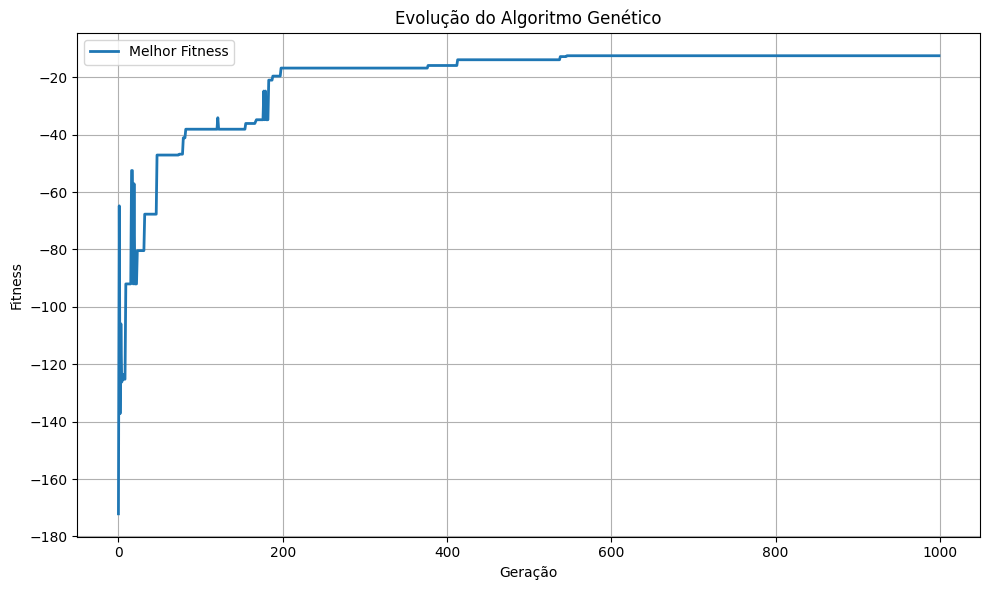

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(fit_max, label='Melhor Fitness', linewidth=2)
plt.xlabel('Geração')
plt.ylabel('Fitness')
plt.title('Evolução do Algoritmo Genético')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()